In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from flaml import AutoML
from flaml import tune

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

import joblib

In [5]:
my_df = pd.read_csv('train_data.csv').drop(['id','EC3','EC4','EC5','EC6'],axis=1)
my_df.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,0,1,1
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,0,0,1
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,0,1,1
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,0,1,1
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,2,1,0


## EDA

In [ ]:
# ProfileReport html page cannot be displayed due to limited memory
# Proceed with manual EDA

In [6]:
my_df.isna().sum()
# no missing values

BertzCT              0
Chi1                 0
Chi1n                0
Chi1v                0
Chi2n                0
Chi2v                0
Chi3v                0
Chi4n                0
EState_VSA1          0
EState_VSA2          0
ExactMolWt           0
FpDensityMorgan1     0
FpDensityMorgan2     0
FpDensityMorgan3     0
HallKierAlpha        0
HeavyAtomMolWt       0
Kappa3               0
MaxAbsEStateIndex    0
MinEStateIndex       0
NumHeteroatoms       0
PEOE_VSA10           0
PEOE_VSA14           0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
SMR_VSA10            0
SMR_VSA5             0
SlogP_VSA3           0
VSA_EState9          0
fr_COO               0
fr_COO2              0
EC1                  0
EC2                  0
dtype: int64

In [7]:
my_df.dtypes
# no categorical values

BertzCT              float64
Chi1                 float64
Chi1n                float64
Chi1v                float64
Chi2n                float64
Chi2v                float64
Chi3v                float64
Chi4n                float64
EState_VSA1          float64
EState_VSA2          float64
ExactMolWt           float64
FpDensityMorgan1     float64
FpDensityMorgan2     float64
FpDensityMorgan3     float64
HallKierAlpha        float64
HeavyAtomMolWt       float64
Kappa3               float64
MaxAbsEStateIndex    float64
MinEStateIndex       float64
NumHeteroatoms         int64
PEOE_VSA10           float64
PEOE_VSA14           float64
PEOE_VSA6            float64
PEOE_VSA7            float64
PEOE_VSA8            float64
SMR_VSA10            float64
SMR_VSA5             float64
SlogP_VSA3           float64
VSA_EState9          float64
fr_COO                 int64
fr_COO2                int64
EC1                    int64
EC2                    int64
dtype: object

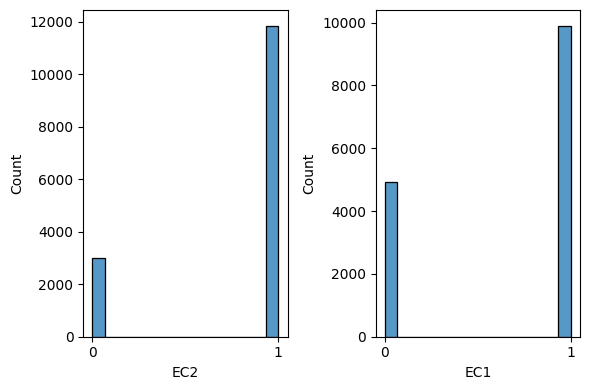

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,4))
fig2 = sns.histplot(my_df['EC1'], ax=axes[1]).locator_params(integer=True)
fig1 = sns.histplot(my_df['EC2'], ax=axes[0]).locator_params(integer=True)
plt.tight_layout()
# classes are a bit unbalanced

## Prepare X, y and perform test-train split

In [9]:
X = my_df.drop(['EC1','EC2'], axis=1)
y = my_df[['EC1','EC2']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

joblib.dump(X.columns.tolist(), '../fit_pickles/feature_names.pkl')

## Check outliers in train data

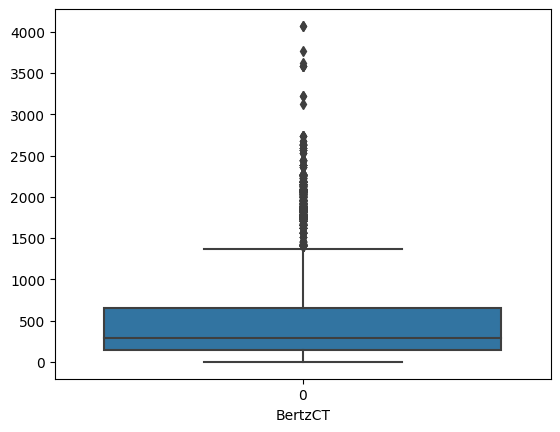

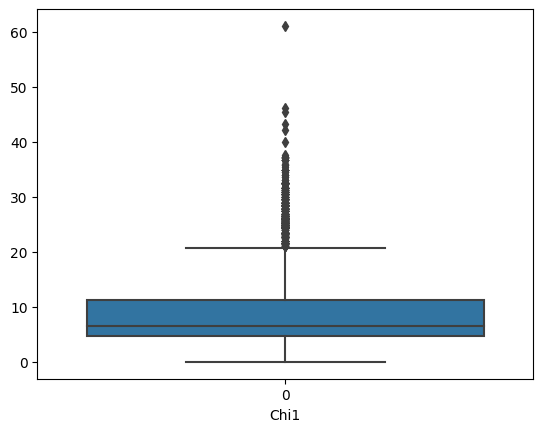

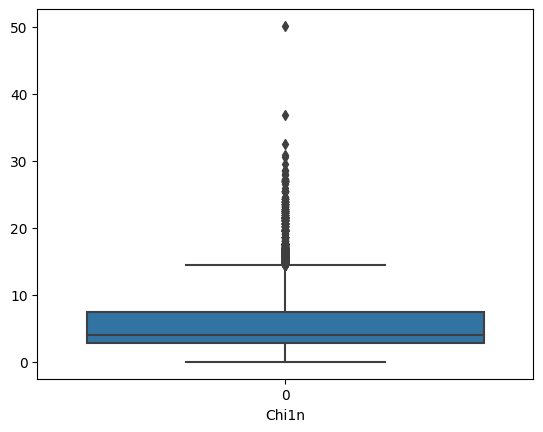

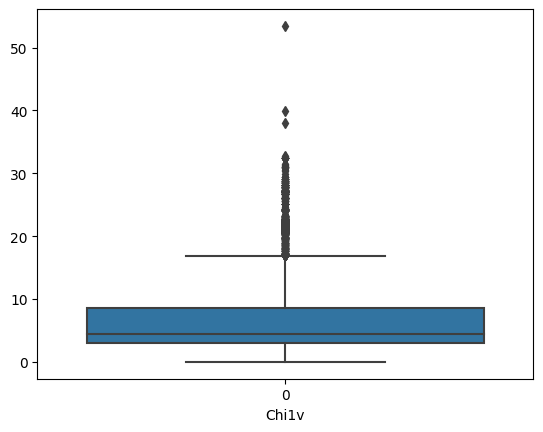

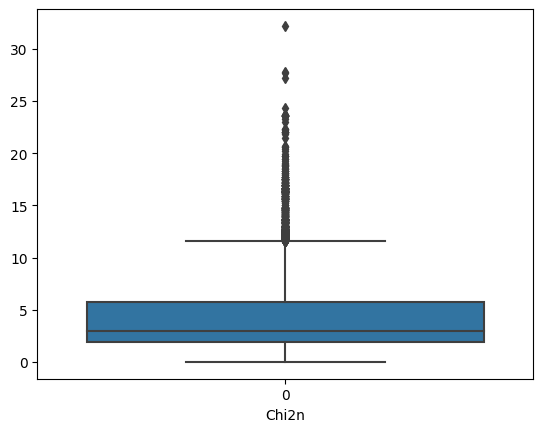

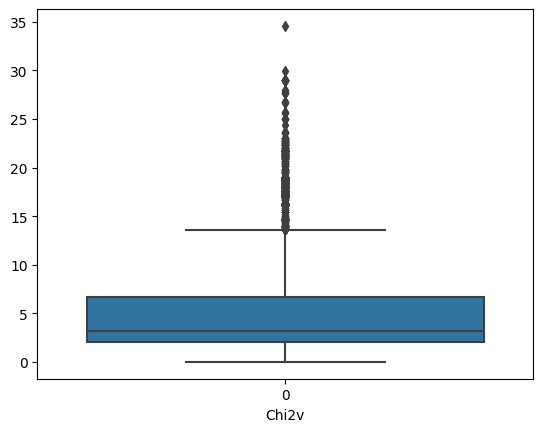

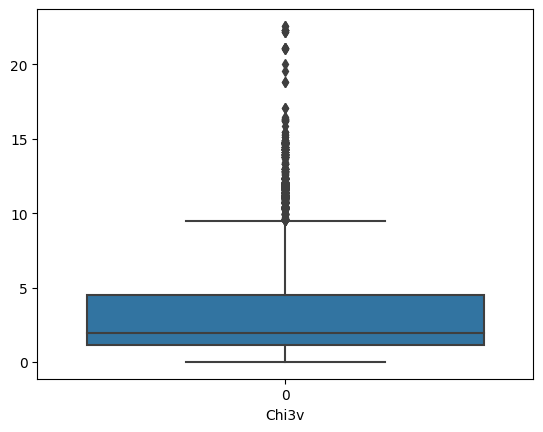

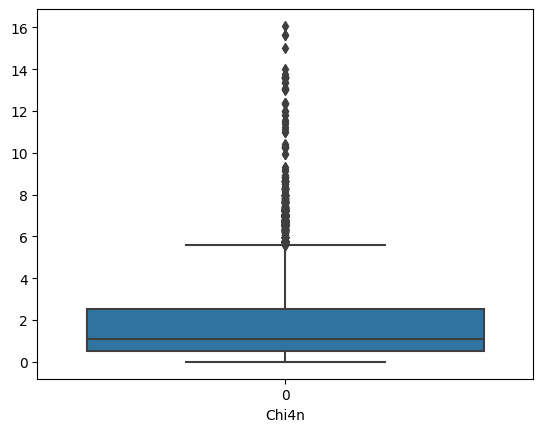

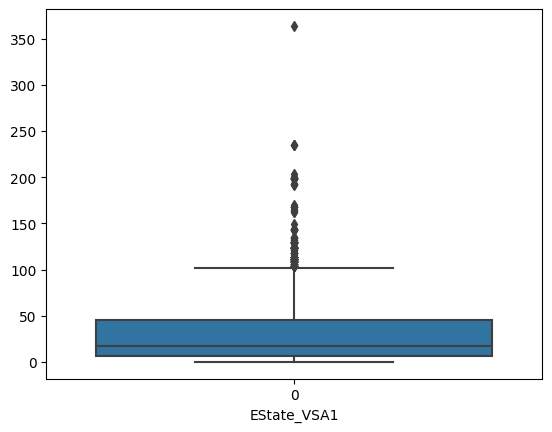

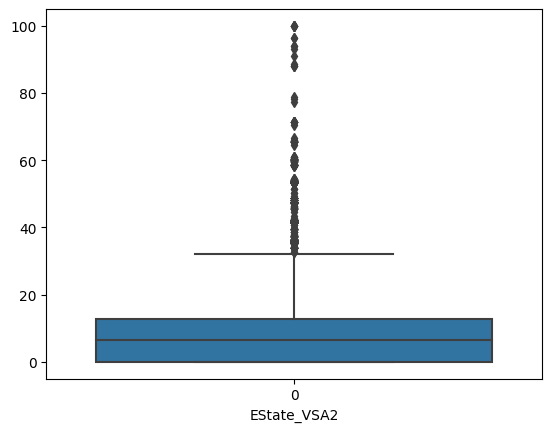

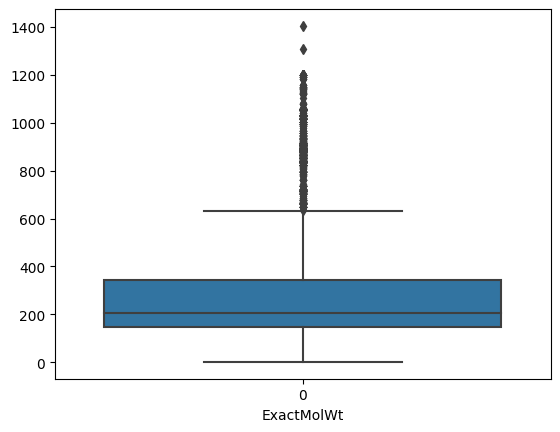

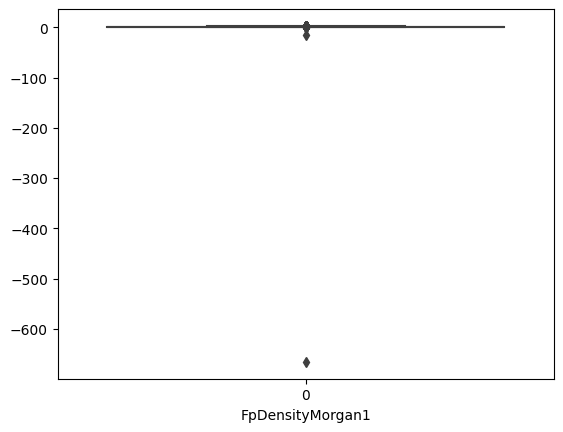

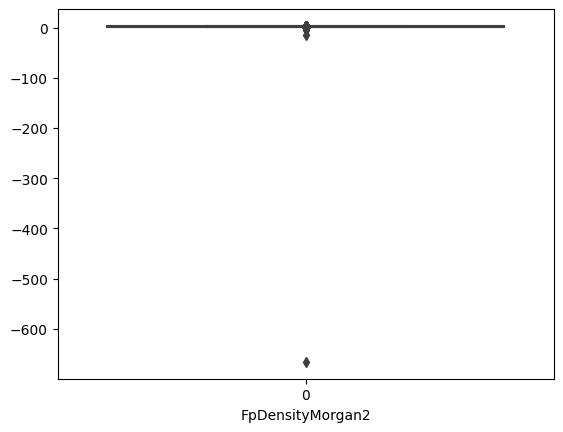

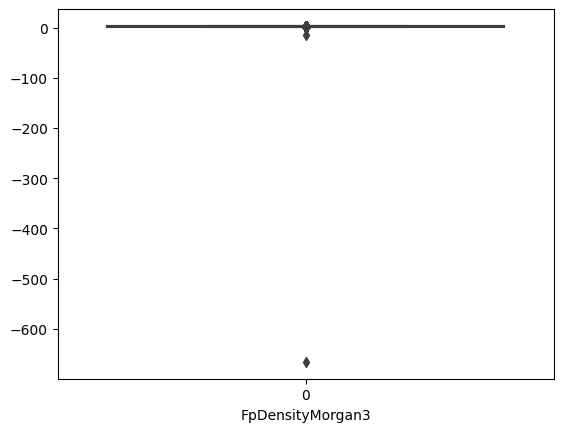

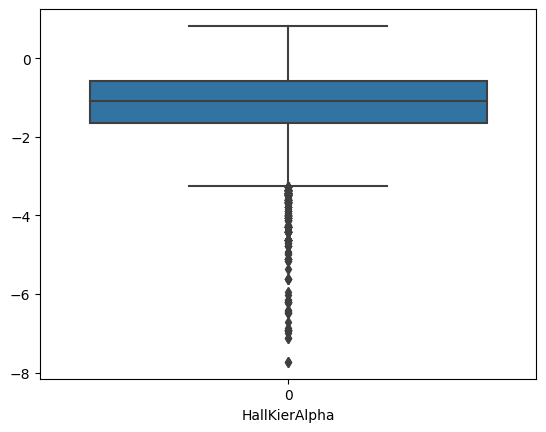

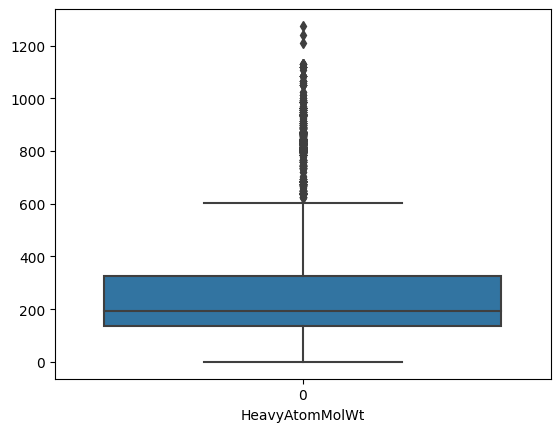

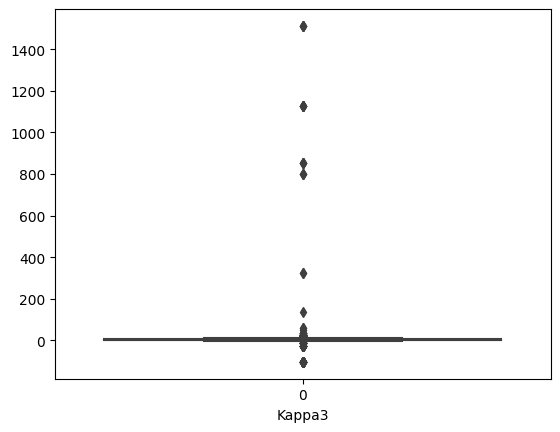

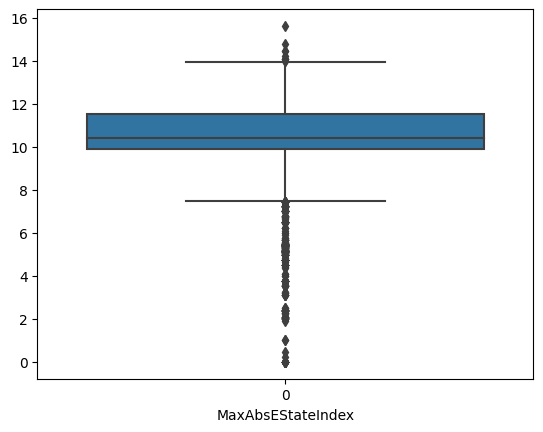

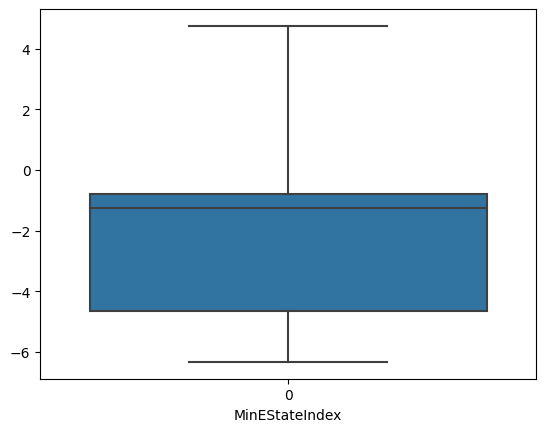

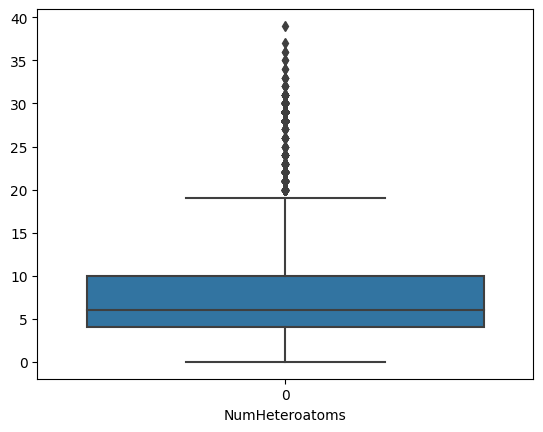

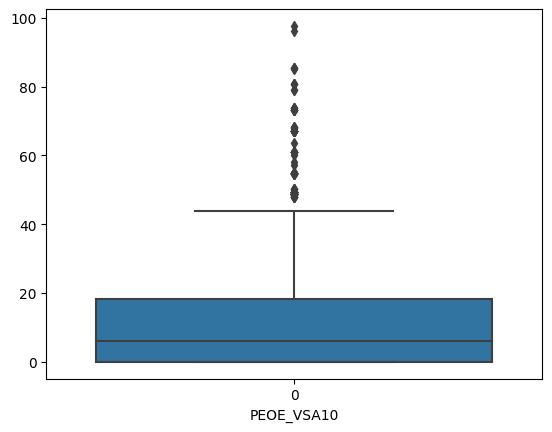

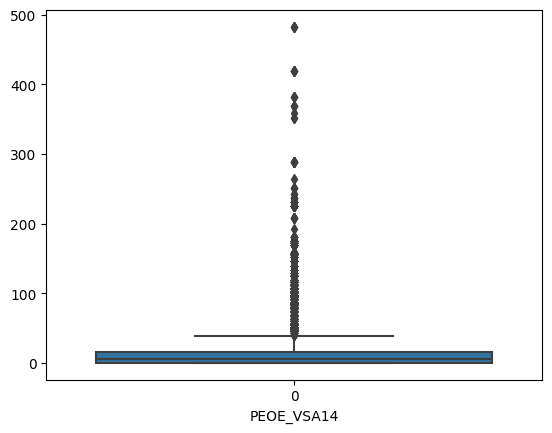

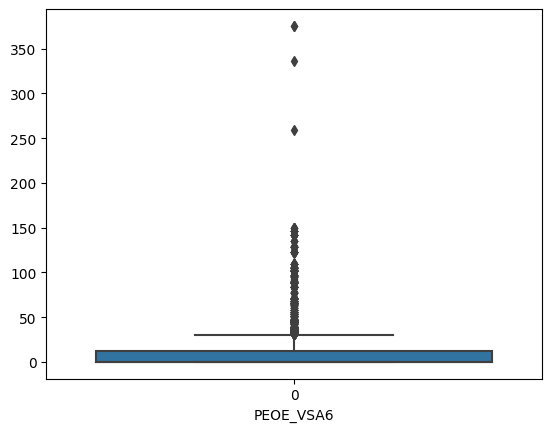

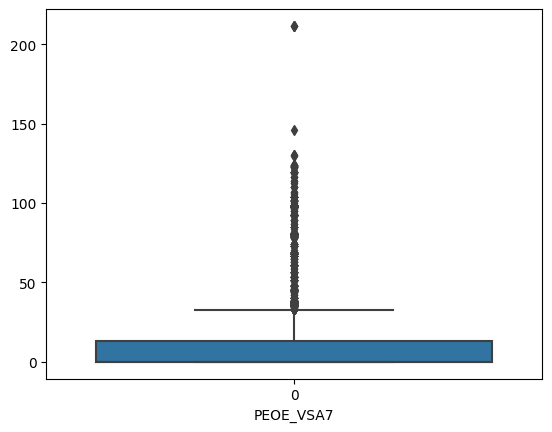

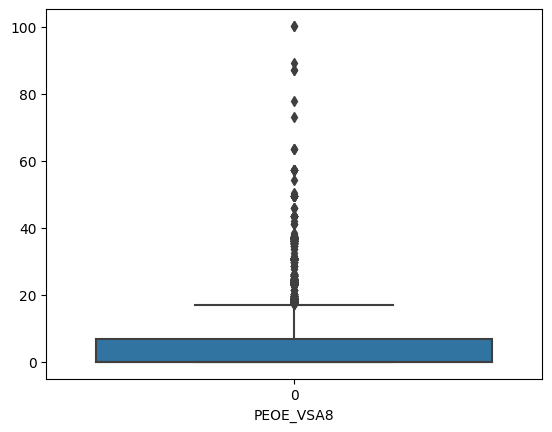

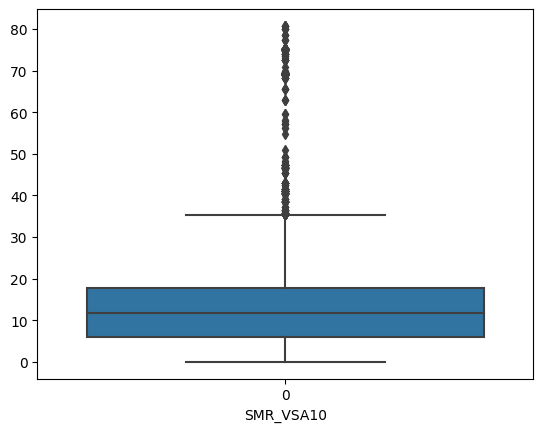

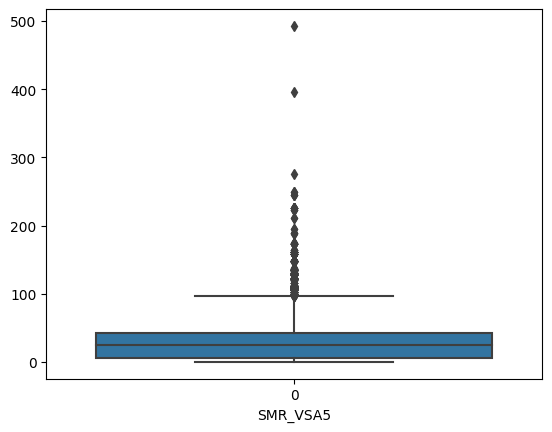

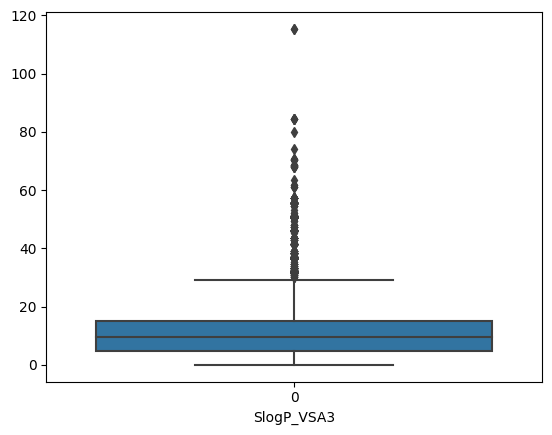

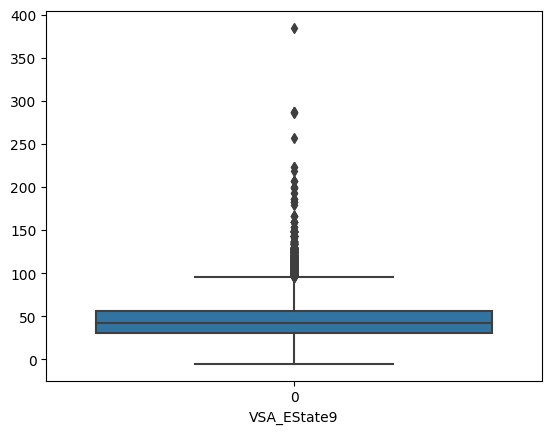

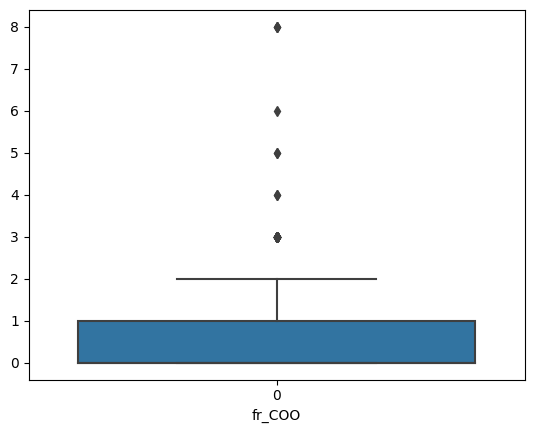

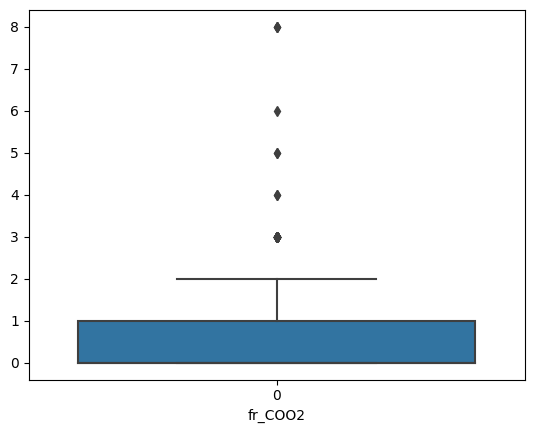

In [10]:
# LocalOutlierFactor doesn't do well. Many features, sparce feature space.
# Elimination by +-3IQR suggests taking out 42% of samples.
# Manually eliminated 2,43% samples by inspecting box plots of each feature.

for column in X_train.columns:
    sns.boxplot(X_train[column])
    plt.xlabel(column)
    plt.show()

In [11]:
len_before = len(X_train)
print('Length before deleting was {}'.format(len_before))

not_outliers_index = X_train[(X_train['BertzCT']<3000)&
                            (X_train['Chi1']<40)&
                            (X_train['Chi1v']<35)&
                            (X_train['Chi2n']<25)&
                            (X_train['EState_VSA1']<150)&
                            (X_train['EState_VSA2']<75)&
                            (X_train['ExactMolWt']<1250)&
                            (X_train['FpDensityMorgan1']>-1)&
                            (X_train['FpDensityMorgan2']>-4)&
                            (X_train['FpDensityMorgan3']>0.1)&
                            (X_train['HeavyAtomMolWt']<1200)&
                            (X_train['Kappa3']<30)&
                            (X_train['Kappa3']>-10)&
                            (X_train['NumHeteroatoms']<38)&
                            (X_train['MinEStateIndex']<5)&
                            (X_train['PEOE_VSA10']<90)&
                            (X_train['PEOE_VSA14']<275)&
                            (X_train['PEOE_VSA6']<200)&
                            (X_train['PEOE_VSA7']<140)&
                            (X_train['PEOE_VSA8']<55)&
                            (X_train['SMR_VSA5']<300)&
                            (X_train['SlogP_VSA3']<80)&
                            (X_train['VSA_EState9']<250)&
                            (X_train['fr_COO']<2.5)&
                            (X_train['fr_COO2']<2.5)
                            ].index.tolist()

X_train = X_train.loc[not_outliers_index]
y_train = y_train.loc[not_outliers_index]

len_after = len(X_train)
print('Length after deleting was {}'.format(len_after))
print('Eliminated {:.2%} samples.'.format((len_before-len_after)/len_before))

Length before deleting was 11870
Length after deleting was 11582
Eliminated 2.43% samples.


## Prepare data for model fitting

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Find best model

In [ ]:
# first ran AutoML with xgboost, rf, lrl1, lrl2 + class_weight = balanced
# XGBoost outperformed, so ran a second time with a single model

automl_label1 = AutoML()
automl_label2 = AutoML()

automl_settings = {'task':'classification',
                   'time_budget':3600,
                   'metric':'roc_auc',
                   'estimator_list':['xgboost']}
automl_settings['custom_hp'] = {
                        'xgboost':{'scale_pos_weight':{'domain': tune.uniform(0.1, 1.0), 'init_value':0.1}}
#                         'rf':{'class_weight':{'domain':'balanced', 'init_value':'balanced'}},
#                         'lrl1':{'class_weight':{'domain':'balanced', 'init_value':'balanced'}},
#                         'lrl2':{'class_weight':{'domain':'balanced', 'init_value':'balanced'}}
                                    }

automl_label1.fit(X_train, y_train['EC1'], **automl_settings)
automl_label2.fit(X_train, y_train['EC2'], **automl_settings)

In [290]:
print('Best performance for label 1 is {}.'.format(1-automl_label1.best_loss))
print('Best performance for label 2 is {}.'.format(1-automl_label2.best_loss))

Best performance for label 1 is 0.7067718267792527.
Best performance for label 2 is 0.5844814879572511.


In [291]:
automl_label1.best_config

{'n_estimators': 1101,
 'max_leaves': 14,
 'min_child_weight': 2.469347420997265,
 'learning_rate': 0.006565277075706342,
 'subsample': 0.8742567681926755,
 'colsample_bylevel': 0.9296317327499974,
 'colsample_bytree': 0.10505643444659167,
 'reg_alpha': 0.0009765625,
 'reg_lambda': 1.1886861351462816,
 'scale_pos_weight': 0.3318973445606912}

In [292]:
automl_label2.best_config

{'n_estimators': 67,
 'max_leaves': 10,
 'min_child_weight': 1.3030159878405707,
 'learning_rate': 0.040308660484772274,
 'subsample': 0.8051656961292349,
 'colsample_bylevel': 0.4780624229731738,
 'colsample_bytree': 0.8914554773028576,
 'reg_alpha': 0.9970408069906573,
 'reg_lambda': 0.004908239969037276,
 'scale_pos_weight': 0.461973671806857}

## Test performance

In [13]:
final_model_EC1 = XGBClassifier(n_estimators= 1101,
                                 max_leaves= 14,
                                 min_child_weight= 2.469347420997265,
                                 learning_rate= 0.006565277075706342,
                                 subsample= 0.8742567681926755,
                                 colsample_bylevel= 0.9296317327499974,
                                 colsample_bytree= 0.10505643444659167,
                                 reg_alpha= 0.0009765625,
                                 reg_lambda= 1.1886861351462816,
                                 scale_pos_weight= 0.3318973445606912)
final_model_EC2 = XGBClassifier(n_estimators= 67,
                                 max_leaves= 10,
                                 min_child_weight= 1.3030159878405707,
                                 learning_rate= 0.040308660484772274,
                                 subsample= 0.8051656961292349,
                                 colsample_bylevel= 0.4780624229731738,
                                 colsample_bytree= 0.8914554773028576,
                                 reg_alpha= 0.9970408069906573,
                                 reg_lambda= 0.004908239969037276,
                                 scale_pos_weight= 0.461973671806857)

final_model_EC1.fit(X_train, y_train['EC1'])
final_model_EC2.fit(X_train, y_train['EC2'])

test_score1 = roc_auc_score(y_test['EC1'], final_model_EC1.predict_proba(X_test)[:,1])
test_score2 = roc_auc_score(y_test['EC2'], final_model_EC2.predict_proba(X_test)[:,1])

print('ROC_AUC score for test data EC1 is {}'.format(test_score1))
print('ROC_AUC score for test data EC2 is {}'.format(test_score2))

ROC_AUC score for test data EC1 is 0.7071843494535375
ROC_AUC score for test data EC2 is 0.5917466343255208


## Train full model, generate prediction on competition data and export submission file

In [16]:
mypred_df = pd.read_csv('test_data.csv').drop(['id'], axis=1)

final_scaler = StandardScaler()
X = final_scaler.fit_transform(X)
mypred_df = final_scaler.transform(mypred_df)

final_model_EC1.fit(X, y['EC1'])
final_model_EC2.fit(X, y['EC2']);

In [17]:
prediction_EC1 = final_model_EC1.predict_proba(mypred_df)[:,1]
prediction_EC2 = final_model_EC2.predict_proba(mypred_df)[:,1]

#export
submission_file = pd.concat([pd.read_csv('test_data.csv')['id'],pd.Series(prediction_EC1),pd.Series(prediction_EC2)], axis=1)
submission_file.columns = ['id', 'EC1', 'EC2']
submission_file.to_csv('submission.csv', index=False)

## Export pickles to be used later on

In [18]:
joblib.dump(final_scaler,'../fit_pickles/fit_scaler.pkl')
joblib.dump(final_model_EC1,'../fit_pickles/fit_EC1_model.pkl')
joblib.dump(final_model_EC2,'../fit_pickles/fit_EC2_model.pkl')

['fit_pickles/fit_EC2_model.pkl']